<Axes: >

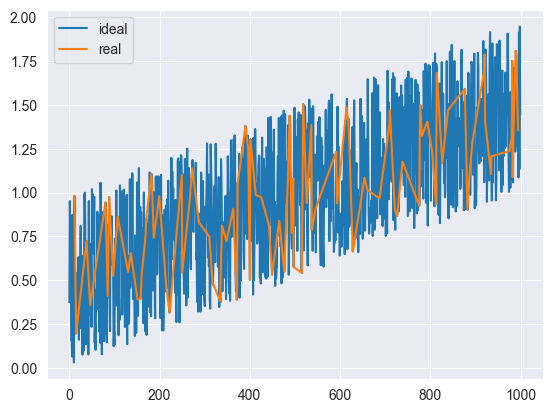

In [298]:
# 为判断算法有效性并直观反映算法效果，先生成一个理想股价时间序列，即等间距、高密度的（t, Pt）序列
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

ideal_timestamps = np.arange(0, 1000, 1)
ideal_prices = np.random.random(size=1000)+np.arange(0, 1000, 1)/1000
# 然后随机生成一个真实的股价时间序列
real_timestamps = ideal_timestamps[np.sort(np.random.randint(0, 1000, 100))]
real_prices = ideal_prices[real_timestamps]

sns.set_style("darkgrid")
sns.lineplot(x=ideal_timestamps, y=ideal_prices, label="ideal")
sns.lineplot(x=real_timestamps, y=real_prices, label="real")

# 用这一组数据来测试算法


SMA:  0.911792631860151


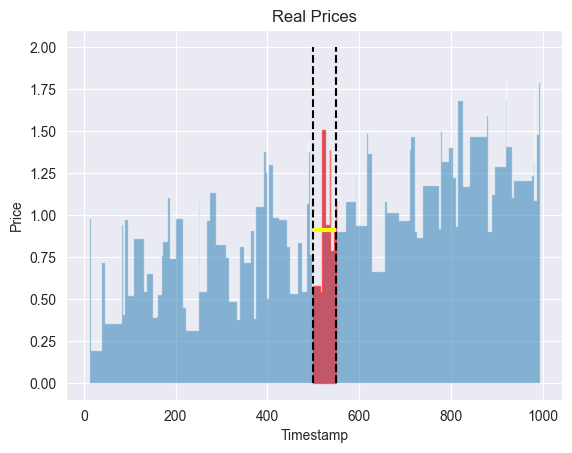

In [300]:

# 先考虑（t, Pt）尚未超出内存限制的情况。例如在len(real_timestamps)==100的情况下，设置内存上限为num_bins=50
# 在这种情况下，只需要根据实际数据，计算[t-W, t]时间段内的平均价格

# 首先考虑如何在该种情况下合理计算MovingAverage
# 由于只需要进行SMA，且“假设在相邻两次数据到达期间内，股票的真实价格都等于前一次数据的价格”，因此可以考虑以积分的方式定义SMA
# 直观地看，首先绘制real_prices相对于real_timestamps的图像，其中在real_timestamps[i]和real_timestamps[i+1]之间的区域，其取值均为real_prices[i]
# 当给定[t-W, t]时，可以通过计算该区域的面积除以W来得到SMA。以t=500,W=50为例，可以得到如下图像

t, W = 550, 50
plt.fill_between(real_timestamps, real_prices, step="post", alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Real Prices')
plt.vlines(t, 0, 2, colors="k", linestyles="dashed")
plt.vlines(t-W, 0, 2, colors="k", linestyles="dashed")

t_start = t-W
t_end = t
t_start_idx = np.where(real_timestamps>=t_start)[0][0]
t_end_idx = np.where(real_timestamps<=t_end)[0][-1]
p_start = real_prices[t_start_idx] if real_timestamps[t_start_idx]==t_start else real_prices[t_start_idx-1]
p_end = real_prices[t_end_idx] if real_timestamps[t_end_idx]==t_end else real_prices[t_end_idx+1]
t_range = np.concatenate([[t_start], real_timestamps[t_start_idx:t_end_idx+1], [t_end]])
p_range = np.concatenate([[p_start], real_prices[t_start_idx:t_end_idx+1], [p_end]])
plt.fill_between(t_range, p_range, step="post", alpha=0.5, color="r")


# 计算这一段的面积并处以W，即可得到SMA，用黄色实线标出
sma = np.trapz(p_range, t_range)/W
print("SMA: ", sma)
plt.hlines(sma, t_start, t_end, colors="yellow",linewidth=3)
plt.show()

# 至此可以给出基于timestamps, prices, t, W的SMA计算函数
# 相比于先将timestamps和prices下采样再计算所关心区间的结果，本算法直接计算所关心区间的结果，性能更优
def SMA(timestamps, prices, t, W):
    t_start = t-W
    t_end = t
    t_start_idx = np.where(timestamps>=t_start)[0][0]
    t_end_idx = np.where(timestamps<=t_end)[0][-1]
    p_start = prices[t_start_idx] if timestamps[t_start_idx]==t_start else prices[t_start_idx-1]
    p_end = prices[t_end_idx] if timestamps[t_end_idx]==t_end else prices[t_end_idx-1]
    t_range = np.concatenate([[t_start], timestamps[t_start_idx:t_end_idx+1], [t_end]])
    p_range = np.concatenate([[p_start], prices[t_start_idx:t_end_idx+1], [p_end]])
    return np.trapz(p_range, t_range)/W

# 此即为MovingAverage.Get()的雏形，为符合题设，只需将t设置为timestamps[-1]即可
# 在题目假设下，这种方法能够顾及数据间隔变化极端的情况下的鲁棒性

In [301]:
# 接下来首先完成未超出内存时的MovingAverage
class MovingAverage:
    def __init__(self, num_bin: int, window: float):
        self.timestamps = np.zeros(num_bin)
        self.prices = np.zeros(num_bin)
        self.w = window

    def Get(self) -> float:
        if (self.timestamps==0).all():
            raise ValueError("No record yet")
        t_current = self.timestamps[np.where(self.timestamps>0)[0][-1]]
        t_start = t_current-self.W
        t_start_idx = np.where(self.timestamps>=t_start)[0][0]
        t_current_idx = np.where(self.timestamps<=t_current)[0][-1]
        p_start = self.prices[t_start_idx] if self.timestamps[t_start_idx]==t_start else self.prices[t_start_idx-1]
        p_end = self.prices[t_current_idx] if self.timestamps[t_current_idx]==t_current else self.prices[t_current_idx+1]
        t_range = np.concatenate([[t_start], self.timestamps[t_start_idx:t_current_idx+1], [t_current]])
        p_range = np.concatenate([[p_start], self.prices[t_start_idx:t_current_idx+1], [p_end]])
        return np.trapz(p_range, t_range)/W
    
    # 为了方便测试，增加一个可视化函数
    def Vis(self):
        plt.fill_between(self.timestamps, self.prices, step="pre", alpha=0.5)
        plt.show()
        
    def Update(self, timestamp: float, value: float):
        try:
            current_idx = np.where(self.timestamps>0)[0][-1]
            self.timestamps[current_idx+1] = timestamp
            self.prices[current_idx+1] = value
        except:
            self.timestamps[0] = timestamp
            self.prices[0] = value

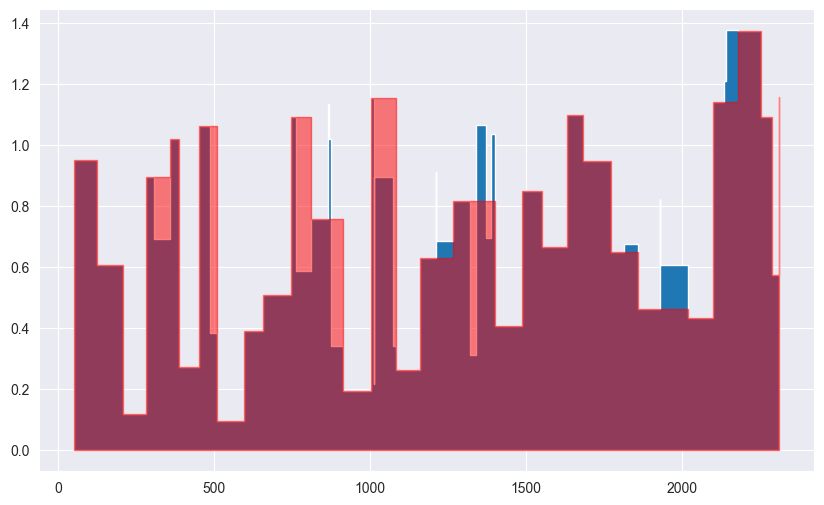

In [302]:
# 当窗口内到达的数据量超过可用的存储空间时，应做一定的取舍，既不突破内存限制，又尽可能保证结果的精确性
# 直观地看，当num_bins满载后，可以将num_bins分辨率降低，为新数据腾空间
# 降低分辨率涉及到合理的插值，是计算量较大的部分。考虑到这一点，如果每次仅将num_bins的数据插值到num_bins-1，那么每更新一次数据就要调用一次插值方法
# 为平衡插值效果与效率，通过实验的方法在模拟数据上比较不同压缩率的插值效果，确定一个基本合理的压缩率

fig = plt.figure(figsize=(10, 6))

# 以num_bins=50为例，模拟前50个数据的添加
np.random.seed(42)
test = MovingAverage(50,50)
timestamp = 0


for i in range(50):
    timestamp += np.random.randint(1, 100)
    price = i/100+(np.random.random())
    test.Update(timestamp, price)

# test.Vis()

# 相比于探究什么样的插值算法合适股价数据，这里直接使用numpy.interp作为示例
# 插值算法的效果关键在于如何选择插值点。由于实际数据可能出现数据间隔变化极端的情况，在原始时间范围内等间距选择插值点显然是不合适的
# 这里考虑以每个时间戳两侧的时间间隔之和的幂次作为权重，从原始时间戳中随机下采样
before_timestamps = test.timestamps
before_prices = test.prices
time_sparsity = before_timestamps[1:]-before_timestamps[:-1]
time_weight = (time_sparsity[:-1]+time_sparsity[1:])**10
# compounds = before_timestamps*before_prices
# compounds_sparsity = compounds[1:]-compounds[:-1]
# compounds_weight = (compounds_sparsity[:-1]+compounds_sparsity[1:])**10

# 以num_kept=30为例，模拟插值后的结果
num_kept = 30

after_timestamps = np.sort(np.random.choice(before_timestamps[1:-1], num_kept-2, p=time_weight/time_weight.sum(), replace=False))
after_timestamps = np.concatenate([[before_timestamps[0]], after_timestamps, [before_timestamps[-1]]])
after_prices = np.interp(after_timestamps, before_timestamps, before_prices)


plt.fill_between(before_timestamps, before_prices, step="post", alpha=1)
plt.fill_between(after_timestamps, after_prices, step="post", alpha=0.5,color="r")

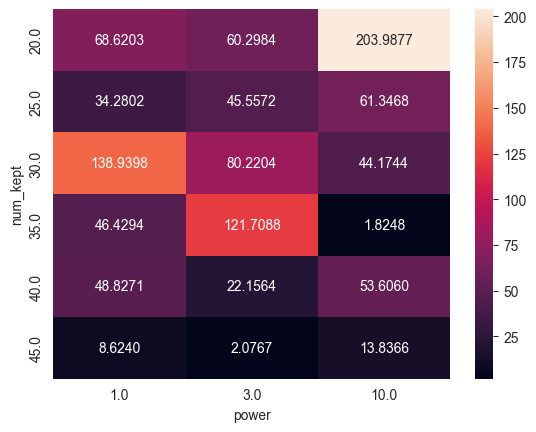

In [303]:
# 接下来在小范围内测试num_kept和权重幂次，选取最优组合。优化指标为插值前后面积之差
import pandas as pd


def TimeCompaction(timestamps, prices, num_kept, power):
    time_sparsity = timestamps[1:]-timestamps[:-1]
    time_weight = (time_sparsity[:-1]+time_sparsity[1:])**power
    after_timestamps = np.sort(np.random.choice(timestamps[1:-1], num_kept-2, p=time_weight/time_weight.sum(), replace=False))
    after_timestamps = np.concatenate([[timestamps[0]], after_timestamps, [timestamps[-1]]])
    after_prices = np.interp(after_timestamps, timestamps, prices)
    return after_timestamps, after_prices

before_timestamps = test.timestamps
before_prices = test.prices
optimization_records = pd.DataFrame(columns=["num_kept", "power", "area_diff"])
line_counter = 0
for num_kept in range(20, 46, 5):
    for power in [1, 3, 10]:
        after_timestamps, after_prices = TimeCompaction(before_timestamps, before_prices, num_kept, power)
        # print("num_kept: ", num_kept, "power: ", power, "area_diff: ", np.trapz(after_prices, after_timestamps)-np.trapz(before_prices, before_timestamps))
        optimization_records.loc[line_counter] = [num_kept, power, np.abs(np.trapz(after_prices, after_timestamps)-np.trapz(before_prices, before_timestamps))]
        line_counter += 1
        
optimization_records = optimization_records.pivot_table(index="num_kept", columns="power", values="area_diff")
sns.heatmap(optimization_records, annot=True, fmt=".4f")
plt.show()

In [308]:
# 可以看到，num_kept==45/power==3时，或num_kept==35/power==10时，面积差均很小，但后者更新频率仅为前者的1/3
# 实际上需要更换随机种子、使用真实数据来做更进一步的超参数优化，但由于这里没有真实数据，进行大量模拟实验意义不大，故选取num_kept==35/power==10组合作为压缩的基准
# 至此，可以完成完整的MovingAverage算法，其中，每当num_bins满载后，将num_bins的数据压缩到num_bins-15，再添加新数据

class MovingAverage:
    def __init__(self, num_bin: int, window: float):
        self.num_bins = num_bin
        self.timestamps = np.zeros(num_bin)
        self.prices = np.zeros(num_bin)
        self.W = window
        self.num_kept = num_bin-15
        self.power = 10
        self.update_counter = 0

    def Get(self) -> float:
        if self.update_counter == 0:
            return 0
        t_current = self.timestamps[np.where(self.timestamps>0)[0][-1]]
        # print(f't_current: {t_current}')
        t_start = t_current-self.W if t_current-self.W > 0 else self.timestamps[0]
        # print(f't_start: {t_start}')
        t_start_idx = np.where(self.timestamps>=t_start)[0][0]
        # print(f't_start_idx: {t_start_idx}')
        t_current_idx = np.where(self.timestamps>=t_current)[0][0]
        # print(f't_current_idx: {t_current_idx}')
        p_start = self.prices[t_start_idx] if self.timestamps[t_start_idx]==t_start else self.prices[t_start_idx-1]
        # print(f'p_start: {p_start}')
        p_end = self.prices[t_current_idx] if (self.timestamps[t_current_idx]==t_current)+(t_current_idx==self.num_bins-1) else self.prices[t_current_idx-1]
        # print(f'p_end: {p_end}')
        t_range = np.concatenate([[t_start], self.timestamps[t_start_idx:t_current_idx+1], [t_current]])
        p_range = np.concatenate([[p_start], self.prices[t_start_idx:t_current_idx+1], [p_end]])
        # print(f't_range: {t_range}')
        # print(f'p_range: {p_range}')
        return np.trapz(p_range, t_range)/self.W
    
    # 为了方便测试，增加一个可视化函数
    def Vis(self):
        plt.fill_between(self.timestamps, self.prices, step="pre", alpha=0.5)
        plt.title(f'{self.update_counter} updates')
        plt.show()
    
    def TC(self): # Time Compaction
        time_sparsity = self.timestamps[1:]-self.timestamps[:-1]
        time_weight = (time_sparsity[:-1]+time_sparsity[1:])**self.power
        after_timestamps = np.sort(np.random.choice(self.timestamps[1:-1], self.num_kept-2, p=time_weight/time_weight.sum(), replace=False))
        after_timestamps = np.concatenate([[self.timestamps[0]], after_timestamps, [self.timestamps[-1]]])
        after_prices = np.interp(after_timestamps, self.timestamps, self.prices)
        return np.concatenate([after_timestamps,np.zeros(15)]), np.concatenate([after_prices,np.zeros(15)])
    
    def Update(self, timestamp: float, value: float):
        self.update_counter += 1
        # 检查是否为第一次更新
        if (self.timestamps==0).all():
            self.timestamps[0] = timestamp
            self.prices[0] = value
        # 检查是否已满载
        elif (self.timestamps>0).all():
            # 已满载则先压缩再添加
            self.timestamps, self.prices = self.TC()
            self.timestamps[self.num_kept] = timestamp
            self.prices[self.num_kept] = value
        # 否则直接添加
        else:
            current_idx = np.where(self.timestamps>0)[0][-1]
            self.timestamps[current_idx+1] = timestamp
            self.prices[current_idx+1] = value
        # print(f'timestamps: {self.timestamps}')

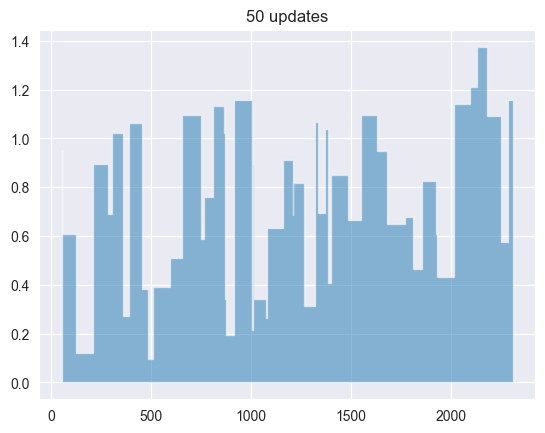

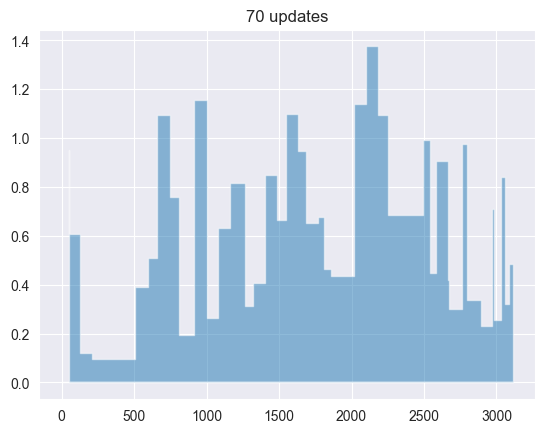

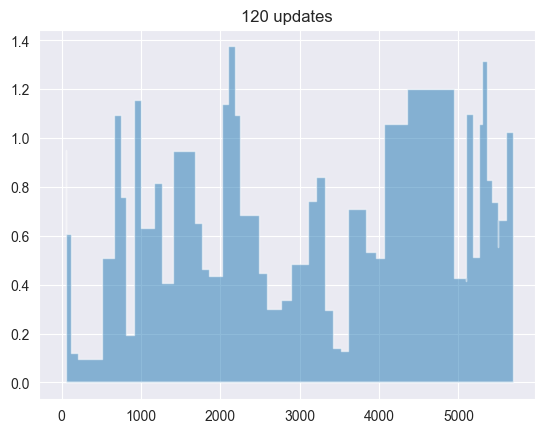

<Axes: >

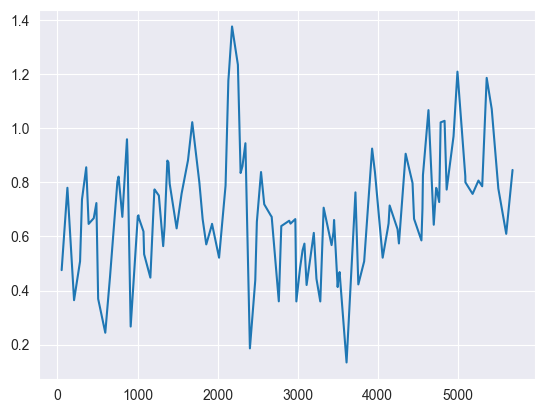

In [309]:
# 最后测试MovingAverage类
# 包括有限内存下的历史数据可视化和[t-W, t]区间内的SMA轨迹可视化

np.random.seed(42)
Final_test = MovingAverage(50,30)
timestamps = []
SMAs = []
# 首先填满num_bins
timestamp = 0
for i in range(50):
    timestamp += np.random.randint(1, 100)
    timestamps.append(timestamp)
    price = i/100+(np.random.random())
    Final_test.Update(timestamp, price)
    SMAs.append(Final_test.Get())
Final_test.Vis()

# 然后添加20个新数据并可视化
for i in range(20):
    timestamp += np.random.randint(1, 100)
    timestamps.append(timestamp)
    price = i/100+(np.random.random())
    Final_test.Update(timestamp, price)
    SMAs.append(Final_test.Get())
Final_test.Vis()

# 然后添加50个新数据并可视化
for i in range(50):
    timestamp += np.random.randint(1, 100)
    timestamps.append(timestamp)
    price = i/100+(np.random.random())
    Final_test.Update(timestamp, price)
    SMAs.append(Final_test.Get())
Final_test.Vis()

sns.lineplot(x=timestamps, y=SMAs)

# 对比SMAs曲线和MovingAverage存储的的数据，可以看到早期数据的多次压缩不可避免地会丢失一些早期信息